# Lecture 10: Multiple Regression and Functional Localizers

## Goals
- **Neuroscience / Neuroimaging concepts**
    - Functional Localizers
    - Regions of Interest (ROIs)
    - ROIs of the visual system
- **Datascience / Coding concepts**
    - Multiple Regression
    - Functional Contrasts of estimated regression weights

# Setup

Simply run the cells below that contain all the Python modules we'll neeed, plus setup matplotlib for plotting in this jupyter notebook.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats
from scipy.stats import zscore
import nibabel
import cortex
import os
from nistats.hemodynamic_models import glover_hrf as create_hrf
import nibabel
from sklearn.linear_model import LinearRegression

from ipywidgets import interact, interactive, fixed, interact_manual, widgets, FloatSlider

np.random.seed(42)

# Set plotting defaults
%matplotlib inline

## Helper Functions
Define a few helper functions that we'll use in this lecture.

In [3]:
def load_nifti(filename, z_score=True, mask=None):
    img = nibabel.load(filename)
    data = img.get_data().T
    if mask is not None:
        data = data[:, mask]
    if z_score:
        data = zscore(data, axis=0)
    return data

In [4]:
# Some helpers for visualization
def show_error_time(x, y, slope, intercept):
    """Plots the whole thing as a time series instead of a point cloud"""
    n = x.shape[0]
    plt.plot(y, 'b')
    plt.hlines([0], x.min(), x.max())
    num_x = 1 if x.ndim == 1 else x.shape[1]
    t = np.arange(n)
    new_x = np.zeros((n,))
    for cur_x in range(num_x):
        cur_x = (intercept + slope[cur_x] * x[:,cur_x])
        new_x += cur_x 
    plt.plot(new_x, 'r', lw=1)
    plt.fill_between(t, new_x, y[:,0], color='g', alpha=.5)

In [5]:
def show_error_scatter(x, y, slope, intercept):
    x = x[:,0]
    y = y[:,0]
    x_left = x.min() - x.ptp() * .2
    x_right = x.max() + x.ptp() * .2
    y_est = slope * x + intercept
    y_left, y_right = slope * x_left + intercept, slope * x_right + intercept
    y_bottom, y_top = y.min() - y.ptp() * .2, y.max() + y.ptp() * .2
    xs = np.vstack([x, x])
    bars = np.vstack([y, y_est])
    plt.hlines([0], x_left, x_right)
    plt.vlines([0], y_bottom, y_top)
    plt.scatter(x, y)
    plt.plot([x_left, x_right], [y_left, y_right], 'r', lw=2)
    plt.plot([0, 0], [0, intercept], 'm', lw=2)
    plt.plot(xs, bars, 'g-.')
    plt.axis([x_left, x_right, y_bottom, y_top])
    return ((y_est - y) ** 2).sum()

In [6]:
def show_error_both_ways(x, y, slope, intercept):
    if x.ndim == 1:
        x = x.reshape(len(x),1)
    if y.ndim == 1:
        y = y.reshape(len(y),1)
    plt.figure(figsize=(20, 4))
    plt.axes([0, 0, .18, 1.])
    e = show_error_scatter(x, y, slope, intercept)
    plt.axes([.2, 0, .8, 1])
    show_error_time(x, y, [slope], intercept)
    print('Sum of squared error (SSE): %.04f' % (e))

## Load the Data


In [7]:
# Get a mask
mask = cortex.db.get_mask('s01', 'catloc', 'cortical')

In [8]:
# specify filenames
filename1 = "/data/cogneuro/fMRI/categories/s01_categories_01.nii.gz"
filename2 = "/data/cogneuro/fMRI/categories/s01_categories_02.nii.gz"
filename3 = "/data/cogneuro/fMRI/categories/s01_categories_03.nii.gz"

In [9]:
# load, mask, zscore, and concatenate the three localizer runs
run1 = load_nifti(filename1, z_score=True, mask=mask)
run2 = load_nifti(filename2, z_score=True, mask=mask)
run3 = load_nifti(filename3, z_score=True, mask=mask)

# Concatenate the data
data = np.concatenate((run1, run2, run3), axis=0)
data.shape

(360, 38543)

In [10]:
# get the faces and places voxels
data_faces = data[:, 3464]
data_places = data[:, 10433]

In [11]:
# Make the design matrix
categories = np.load("/home/jovyan/catloc_experimental_conditions.npy")
unique_categories_no_nothing = np.unique(categories[categories != 'nothing'])
hrf = create_hrf(tr=2, oversampling=1, time_length=32)
stimulus_vectors = []
designmat_full = np.zeros((len(categories), len(unique_categories_no_nothing)))
for i in np.arange(len(unique_categories_no_nothing)):
    unique_category = unique_categories_no_nothing[i]
    stimulus_vectors.append(categories == unique_category)
    designmat_full[:,i] = np.convolve(stimulus_vectors[i], hrf)[:len(stimulus_vectors[i])]
designmat_full.shape

(360, 5)

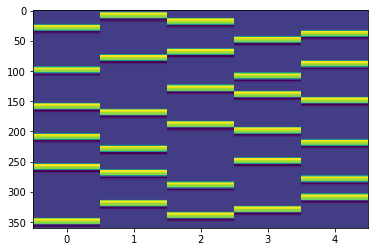

In [12]:
plt.imshow(designmat_full, aspect='auto')

# Review

## Linear Regression

Last class we reviewed correlation and introduced linear regression in one variable. We had established that if an x-y pointcloud is shown in standard units the correlation indicates the slope of the best fitting line through the origin. We write $\hat y$ for the points on that line and $r$ for the correlation have the relationship
$$\hat y = r x.$$

Regression deals with the general case, where we would like to fit a line through an arbitrary point cloud that is not necessarily centered in the origin. The diagram on the top shows the regression line in standard units. To go from standard units to the original units everything needs to be rescaled.

<img src="figures/regline_z.png" />
<img src="figures/regline_orig.png" />

Writing out the difference quotient we obtained
$$\frac{\hat y - \bar y}{SD(y)} = r\frac{x - \bar x}{SD(x)}$$

Regression expresses $\hat y$ as a funtion of $x$, so we reorganized the formula into
$$\hat y = \bar y + SD(y)r\frac{x - \bar x}{SD(x)}$$

Collecting terms with and without $x$ together we get 
$$\hat y = \frac{SD(y)}{SD(x)}r x + \bar y - \frac{SD(y)}{SD(x)}r\bar x$$
And we wrote
$$\hat y = \textrm{slope}\cdot x + \textrm{intercept},$$
with
$$\textrm{slope} = \frac{SD(y)}{SD(x)}r$$
$$\textrm{intercept} = \bar y - \textrm{slope}\cdot\bar x$$

It turns out that these quantities, *slope* and *intercept*, computed in this way, define the line which minimizes the *Sum of Squared Errors* and *Mean Squared Error*, which basically computes how far off the line is from the point cloud on the y-axis:

For each point $(x_i, y_i)$ we can write 
$$e_i = y_i - (\textrm{slope}\cdot x_i + \textrm{intercept})$$
This is called a *residual* (also known as the error term). We square the residuals $e_i$ to make them positive, then add all of them up for all the points and get
$$SSE = \sum_i e_i^2$$
If you are curious, you can try to minimize this sum of squared errors by taking the derivatives with respect to slope and intercept and setting them to zero.

Let's recall some functions from last class and the homework and re-create the visualization widget fitting regressions by hand:

In [13]:
def multiply_add(one_x, many_y):
    return np.dot(one_x, many_y)

def correlate(one, many):
    one_z = zscore(one)
    many_z = zscore(many, axis=0)
    product_sum = multiply_add(one_z, many_z)
    return product_sum / len(one_z)

Using this function `correlate`, we were able to compute correlations of one response vector to *all voxels at the same time*:

In [14]:
faces_response_vec = designmat_full[:, unique_categories_no_nothing == 'faces'].reshape(-1)

In [15]:
corr_faces = correlate(faces_response_vec, data)
corr_faces.shape

(38543,)

**INTERLUDE** (not exam-relevant, but useful for intuition lower down)

We can modify `multiply_add` ever so slightly, and get a function that correlates **all response vectors with all voxels**!

In [16]:
# The secret lies in the TRANSPOSE:
def multiply_add(many_x, many_y):
    return np.dot(many_x.T, many_y)

def correlate(many_x, many_y):
    many_x_z = zscore(many_x, axis=0)
    many_y_z = zscore(many_y, axis=0)
    product_sum = multiply_add(many_x_z, many_y_z)
    return product_sum / many_x.shape[0]

In [17]:
corr_all = correlate(designmat_full, data)
corr_all.shape

(5, 38543)

**END INTERLUDE** (end of non-exam-relevant cells)

#### Regression visualization
Now let's remind ourselves of some ways of visualizing time series data and regression lines. When working with two scalar quantities, we can make a scatterplot and draw a line through it. We can also visualize the voxel time series and the fitted response vector next to each other. The latter visualization will also generalize to multiple regression.

Let's take a look at both of them in this interactive plot for a faces-responsive voxel and the faces response vector:

In [18]:
def show_error_voxel_both(slope, intercept):
    return show_error_both_ways(faces_response_vec, data_faces, slope, intercept)

interactive_plot = interactive(show_error_voxel_both, 
                               slope=widgets.FloatSlider(value=0, min=-5, max=5), 
                               intercept=widgets.FloatSlider(value=0, min=-5, max=5))
output = interactive_plot.children[-1]
output.layout.height = '250px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='slope', max=5.0, min=-5.0), FloatSlider(value=0.0, description='intercept', max=5.0, min=-5.0), Output(layout=Layout(height='250px'))), _dom_classes=('widget-interact',))

After working a bit with the interactive plot, let's compute the exact values for slope and intercept:

In [19]:
def calc_slope(x, y):
    sx = np.std(x)
    sy = np.std(y)
    r = correlate(x, y)
    return r * sy / sx

def calc_intercept(x, y):
    mx = np.mean(x)
    my = np.mean(y)
    slope = calc_slope(x, y)
    return my - slope * mx

In [20]:
slope = calc_slope(faces_response_vec, data_faces)
intercept = calc_intercept(faces_response_vec, data_faces)
print(slope, intercept)

1.50949991545 -0.251584649087


Now we can call the visualization again with these precise values. What we then see is the best fit in the sense that it minimizes the some of squared errors.

Sum of squared error (SSE): 222.4121


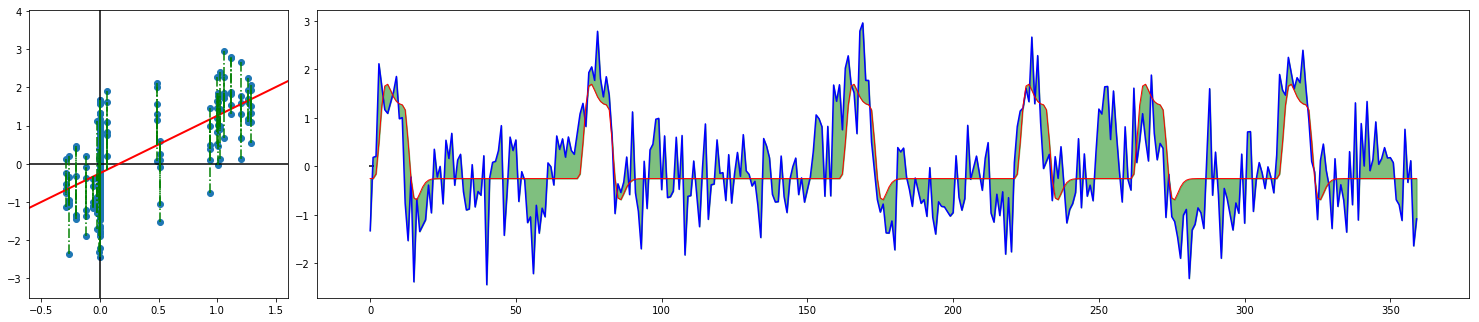

In [21]:
show_error_voxel_both(slope, intercept)

# Linear Regression for real fMRI data

Now let's continue applying linear models to real fMRI data. As introduced in last lecture, this time we'll use a linear regression estimator from scikit-learn to get another glimpse at this software package. We'll fit the faces response vector to our FFA voxel and see how we do.

In [22]:
reg_model_faces = LinearRegression()
reg_model_faces.fit(faces_response_vec, data_faces)

ValueError: Expected 2D array, got 1D array instead:
array=[  0.00000000e+00   0.00000000e+00   6.28941574e-02   4.89625060e-01
   1.00019158e+00   1.26431831e+00   1.28860969e+00   1.20565613e+00
   1.11524786e+00   1.05432646e+00   1.02233456e+00   1.00818812e+00
   9.39809895e-01   5.11166732e-01  -1.05071207e-05  -2.64318307e-01
  -2.88609691e-01  -2.05656135e-01  -1.15247861e-01  -5.43264616e-02
  -2.23345602e-02  -8.18811664e-03  -2.70405256e-03  -7.91792828e-04
  -1.81076075e-04   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   6.28941574e-02   4.89625060e-01   1.00019158e+00   1.26431831e+00
   1.28860969e+00   1.20565613e+00   1.11524786e+00   1.05432646e+00
   1.02233456e+00   1.00818812e+00   9.39809895e-01   5.11166732e-01
  -1.05071207e-05  -2.64318307e-01  -2.88609691e-01  -2.05656135e-01
  -1.15247861e-01  -5.43264616e-02  -2.23345602e-02  -8.18811664e-03
  -2.70405256e-03  -7.91792828e-04  -1.81076075e-04   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   6.28941574e-02   4.89625060e-01
   1.00019158e+00   1.26431831e+00   1.28860969e+00   1.20565613e+00
   1.11524786e+00   1.05432646e+00   1.02233456e+00   1.00818812e+00
   9.39809895e-01   5.11166732e-01  -1.05071207e-05  -2.64318307e-01
  -2.88609691e-01  -2.05656135e-01  -1.15247861e-01  -5.43264616e-02
  -2.23345602e-02  -8.18811664e-03  -2.70405256e-03  -7.91792828e-04
  -1.81076075e-04   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   6.28941574e-02   4.89625060e-01
   1.00019158e+00   1.26431831e+00   1.28860969e+00   1.20565613e+00
   1.11524786e+00   1.05432646e+00   1.02233456e+00   1.00818812e+00
   9.39809895e-01   5.11166732e-01  -1.05071207e-05  -2.64318307e-01
  -2.88609691e-01  -2.05656135e-01  -1.15247861e-01  -5.43264616e-02
  -2.23345602e-02  -8.18811664e-03  -2.70405256e-03  -7.91792828e-04
  -1.81076075e-04   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   6.28941574e-02   4.89625060e-01
   1.00019158e+00   1.26431831e+00   1.28860969e+00   1.20565613e+00
   1.11524786e+00   1.05432646e+00   1.02233456e+00   1.00818812e+00
   9.39809895e-01   5.11166732e-01  -1.05071207e-05  -2.64318307e-01
  -2.88609691e-01  -2.05656135e-01  -1.15247861e-01  -5.43264616e-02
  -2.23345602e-02  -8.18811664e-03  -2.70405256e-03  -7.91792828e-04
  -1.81076075e-04   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   6.28941574e-02   4.89625060e-01   1.00019158e+00   1.26431831e+00
   1.28860969e+00   1.20565613e+00   1.11524786e+00   1.05432646e+00
   1.02233456e+00   1.00818812e+00   9.39809895e-01   5.11166732e-01
  -1.05071207e-05  -2.64318307e-01  -2.88609691e-01  -2.05656135e-01
  -1.15247861e-01  -5.43264616e-02  -2.23345602e-02  -8.18811664e-03
  -2.70405256e-03  -7.91792828e-04  -1.81076075e-04   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Uh-Oh, why didn't that work? Remember that we need to reshape vectors to 1-D matrices. This is annoying now, but will become useful once we want to find regression models to multiple voxels at the same time!

In [23]:
reg_model_faces = LinearRegression()
reg_model_faces.fit(faces_response_vec.reshape(-1,1), data_faces.reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Cool, that did work now!

OK. Where is the info hidden? In all scikit-learn estimators, the properties computed during `fit` are stored in names with *trailing underscore*. In this case it is `.intercept_` and `.coef_`.

In [24]:
reg_model_faces.intercept_, reg_model_faces.coef_

(array([-0.25158464]), array([[ 1.5094999]]))

As we can see, these values correspond to `slope` and `intercept` computed above. 

Let's see how good this model is by calculating the SSE:

In [25]:
data_faces_pred_faces = reg_model_faces.predict(faces_response_vec.reshape(-1,1))[:,0]

In [26]:
faces_sse = np.sum((data_faces - data_faces_pred_faces) **2)
faces_sse

222.41211662697611

Let's plot the data and the regression line to see how well it fits.

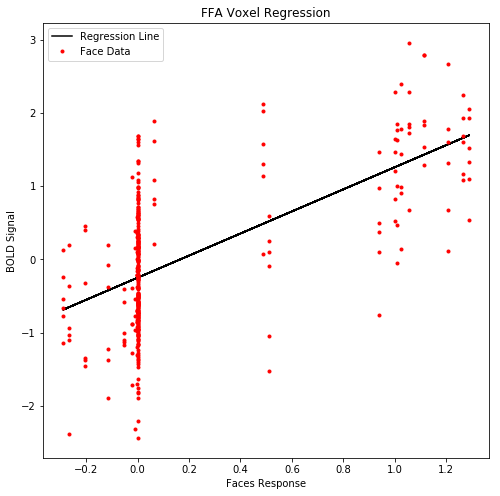

In [27]:
fig = plt.figure(figsize=(8,8))
plt.plot(faces_response_vec, data_faces_pred_faces, 'k', label='Regression Line')
plt.plot(faces_response_vec, data_faces, '.r', label='Face Data')
plt.xlabel('Faces Response')
plt.ylabel('BOLD Signal')
plt.title('FFA Voxel Regression')
_ = plt.legend()

#### Breakout Session

1\. Fit a linear regression model to the PPA voxel BOLD data using the `places` response vector. Plot the data as a scatter plot, and the regression line.

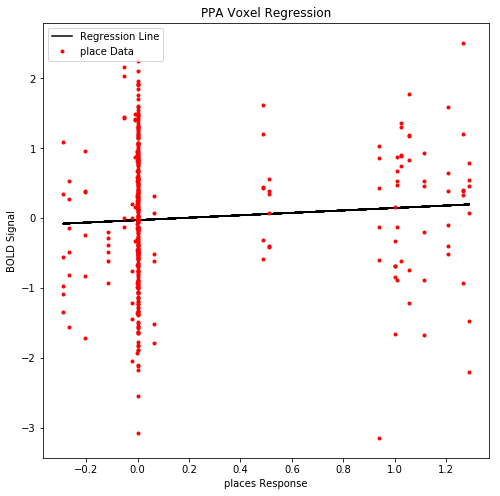

In [54]:
### STUDENT ANSWER

places_response_vec = designmat_full[:, unique_categories_no_nothing == 'places'].reshape(-1)
reg_model_places = LinearRegression()
reg_model_places.fit(places_response_vec.reshape(-1,1), data_places.reshape(-1,1))

data_places_pred_places = reg_model_places.predict(places_response_vec.reshape(-1,1))[:,0]

fig = plt.figure(figsize=(8,8))
plt.plot(places_response_vec, data_places_pred_places, 'k', label='Regression Line')
plt.plot(places_response_vec, data_places, '.r', label='place Data')
plt.xlabel('places Response')
plt.ylabel('BOLD Signal')
plt.title('PPA Voxel Regression')
_ = plt.legend()

places_sse = ((data_places_pred_places - data_places) ** 2).sum()
### END STUDENT ANSWER

In [32]:
reg_model_places.coef_

array([[ 0.17402692]])

# Multiple Linear Regression

The real power of regression comes when we have more than one **independent variable** we want to associate with the **dependent variable**.

The case of multiple linear regression is a natural extension of the simple linear regression case. In multiple regression, we have multiple independent variables ($x^i$), and still a single dependent variable (y). Now the equation describing each time point of data looks like this: 

\begin{align}
y_j =  w_0 + w_1 x^1_j + w_2 x^2_j + \dots + w_d x^d_j +\varepsilon_j
\end{align}

We can rewrite this second equation for multiple regression using a more succinct notation:

\begin{align}
Y =  {\bf X}W + w_0 +\varepsilon,
\end{align}

where
- $Y$ is the n x 1 array of BOLD data
- ${\bf X}$ is the n x d matrix were each of the columns is a response vector (${\bf X}_{ji} = x^i_j$)
- ${W}$ is d x 1, contains all the $w_i$
- $\varepsilon$ is the n x 1 vector of errors, or residuals

We can write the solution to this multiple regression model as the following equation, which is what we will use to fit our model. This is just for your own information - you don't need to know this equation for any exams:

\begin{align}
\hat W = ({\bf X}^\top{\bf X})^{-1}{\bf X}^\top Y\\
\end{align}

Even though the above formula is not necessary for exams, take a good look at it, and try to peel apart what it means. It is likely that you will encounter it more than once throughout your career. Disregard the $({\bf X}^\top{\bf X})^{-1}$ for a bit and take a look at the rest (${\bf X}^\top Y$). Does it ring a bell? If not, refer back to the non-exam-relevant interlude from above.

As it turns out, the equation that minimizes the Sum of Squared Errors (SSE) is exactly the same for the multiple regression case as it is for the simple linear regression case, so we can use the same `LinearRegression` function for both! Let's explore this...

## Extending the Face Model: Modeling Faces and Bodies

Since we know that the subject saw more than just images of faces, it makes sense that we would want to model more than just the response to faces in order to get a model that better explains the BOLD data (y). Now let's see what happens if we include the bodies response vector in the model as well...

### Intuition using time series plots

First let's plot the FFA BOLD data along with the response vectors for the faces and bodies to remind ourselves what the signal looks like when bodies were shown.

In [33]:
bodies_response_vec = designmat_full[:, unique_categories_no_nothing == 'body'].reshape(-1)

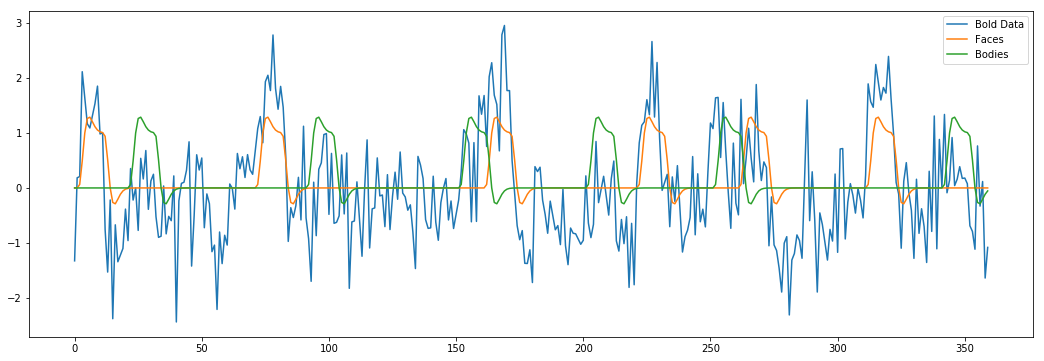

In [34]:
_ = plt.figure(figsize=(18, 6))
_ = plt.plot(data_faces, label = 'Bold Data')
_ = plt.plot(faces_response_vec, label = 'Faces')
_ = plt.plot(bodies_response_vec, label = 'Bodies')
_ = plt.legend()

Now we need to create a 2-D $x$ matrix, which is called a **design matrix**, from the response vectors for bodies and faces. We'll use `np.stack` to do that. 

In [35]:
designmat_faces_bodies = np.stack((faces_response_vec, bodies_response_vec), axis=1)
designmat_faces_bodies.shape

(360, 2)

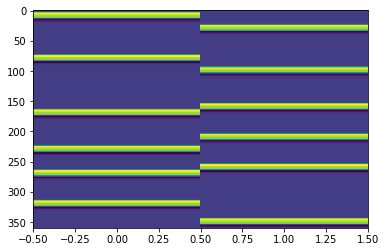

In [36]:
plt.imshow(designmat_faces_bodies, aspect='auto')

And reshape the FFA voxel BOLD data into a 2-D matrix with one column.

In [37]:
data_faces_2D = data_faces.reshape(len(data_faces),1)

In [38]:
def show_error_faces_bodies(intercept, slope_faces, slope_bodies):
    plt.figure(figsize=(15,5))
    show_error_time(designmat_faces_bodies, 
                    data_faces_2D, 
                    [slope_faces, slope_bodies], 
                    intercept)
    sse = ((data_faces - 
            (designmat_faces_bodies.dot([slope_faces, slope_bodies]) + intercept)) ** 2).sum()
    print("Sum of squared errors {}".format(sse))

interactive_plot = interactive(show_error_faces_bodies, 
                               intercept=widgets.FloatSlider(value=0, min=-5, max=5), 
                               slope_faces=widgets.FloatSlider(value=0, min=-5, max=5), 
                               slope_bodies=widgets.FloatSlider(value=0, min=-5, max=5))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot


interactive(children=(FloatSlider(value=0.0, description='intercept', max=5.0, min=-5.0), FloatSlider(value=0.0, description='slope_faces', max=5.0, min=-5.0), FloatSlider(value=0.0, description='slope_bodies', max=5.0, min=-5.0), Output(layout=Layout(height='350px'))), _dom_classes=('widget-interact',))

### Fit the model

Now let's fit a multiple regression model using both the faces and the bodies response vectors as independent variables. We just learned that the same equation estimates the coefficients for simple and multiple linear regression, so we can use the same `LinearRegression` object to fit this multiple regression model. Instead of reshaping a single response vector into a 2-D matrix, we'll use the design matrix we just created. We'll use the reshaped FFA voxel BOLD data and fit the model.

In [39]:
reg_model_face_body = LinearRegression()
reg_model_face_body.fit(designmat_faces_bodies, data_faces_2D)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Let's have a look at the coefficient for faces from this model and from the first regression model of faces that we built. There are 2 slope coefficients now, and since the faces response vector was in the first column, the first coefficient is for faces.

In [41]:
reg_model_face_body.coef_, reg_model_face_body.intercept_

(array([[ 1.614408  ,  0.53972029]]), array([-0.35907398]))

In [42]:
print('Faces Coefficient with Bodies: %.03f' % (reg_model_face_body.coef_[0][0]))
print('Faces Coefficient Only: %.03f' % (reg_model_faces.coef_[0][0]))

Faces Coefficient with Bodies: 1.614
Faces Coefficient Only: 1.509


The two coefficients are similar, but not the same! We'll learn more about why this is later on. 

For now let's predict the original data using this faces and bodies model, and then calculate the sum of squared error (SSE) of this new model. Then we can compare this SSE value with the SSE we calculated above for the faces only model. 

In [43]:
data_faces_pred_facebody = reg_model_face_body.predict(designmat_faces_bodies)[:, 0]
faces_bodies_sse = np.sum((data_faces - data_faces_pred_facebody) ** 2)
faces_bodies_sse, faces_sse

(205.49074540640561, 222.41211662697611)

Since the SSE for the faces bodies model is lower than that for the faces only model we can conclude that including the bodies response vector into the model improves the fit!

#### Breakout Session

1\. Fit a multiple linear regression model to the PPA voxel that has 2 independent variables, the `places` and `object` response vectors. Calculate the predicted values, and use them to calculate the SSE.

In [55]:
### STUDENT ANSWER
objects_response_vec = designmat_full[:, unique_categories_no_nothing == 'object'].reshape(-1)

designmat_places_objects = np.stack((places_response_vec, objects_response_vec), axis=1)
designmat_places_objects.shape

data_places_2d = data_places.reshape(-1, 1)

reg_model_places_objects = LinearRegression()
reg_model_places_objects.fit(designmat_places_objects, data_places_2d)

data_places_pred_places_objects = reg_model_places_objects.predict(designmat_places_objects)[:, 0]
places_objects_sse = np.sum((data_places - data_places_pred_places_objects) ** 2)
places_objects_sse, places_sse
### END STUDENT ANSWER

(351.24454695368161, 358.1712680657169)

## The Full Model with All the Categories

We saw that the model that incorporated bodies and faces did a better job than the model which just incorporated faces. Let's see what happens when we include the response vectors that describe all the stimuli that the subject saw.

We'll do this for 5 voxels that are selective to the different stimulus types.

In [67]:
voxel_indices = np.array([16521, 3464, 8701, 8318, 8806, 10433])
five_voxels = data[:, voxel_indices]
five_voxels.shape

(360, 6)

Let's plot the time series of these 5 voxels to get an idea of what they look like.

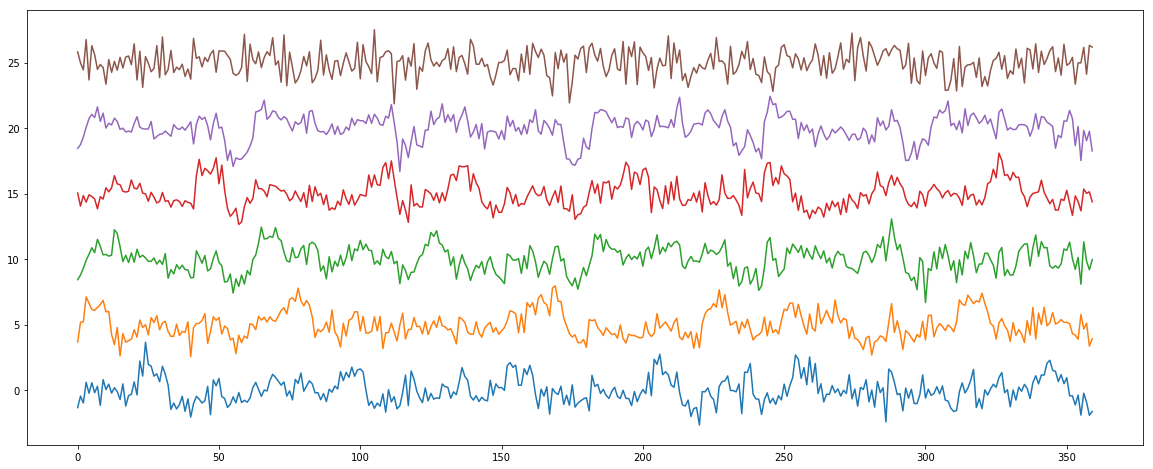

In [68]:
plt.figure(figsize=(20, 8))
for i in range(len(voxel_indices)):
    timeseries = five_voxels[:, i]
    plt.plot(timeseries + 5 * i)    

Now we'll fit a multiple regression model in the same way.

In [69]:
reg_model_full = LinearRegression()
reg_model_full.fit(designmat_full, five_voxels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

And let's predict and calculate the SSE again for the faces voxel, so we can compare it with the faces bodies model.

In [70]:
data_faces_pred_full = reg_model_full.predict(designmat_full)[:,1]
full_sse = np.sum((data_faces-data_faces_pred_full)**2)
print('Just using Faces and bodies, SSE is: %.02f, adding all categories SSE is: %.02f' % (faces_bodies_sse, full_sse))

Just using Faces and bodies, SSE is: 205.49, adding all categories SSE is: 202.56


It seems the SSE is slightly lower when adding all of the response vectors, but not by much! What matters in statistics is whether this is **significantly** lower. We'll learn about significance testing in the next lecture. 

Because adding the remaining regressors does not seem to reduce the error very much anymore, it seems unlikely that our voxel responds significantly to the added categories. However, using the full set of response vectors in regression is going to be useful when working with the full brain - there may be voxels that are very well modeled by these additional response vectors.

Finally, let's plot the real BOLD data time series along with the predicted time series from using multiple regression to visualize how well the model fits.

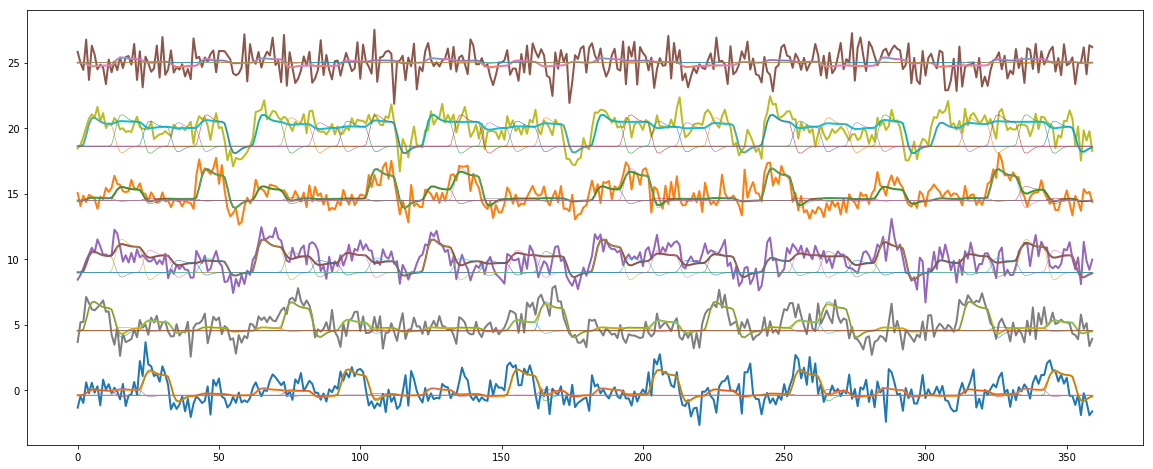

In [71]:
predictions = reg_model_full.predict(designmat_full)

weights = reg_model_full.coef_
intercepts = reg_model_full.intercept_

plt.figure(figsize=(20, 8))
for i in range(len(voxel_indices)):
    timeseries = five_voxels[:, i]
    prediction = predictions[:, i]
    plt.plot(timeseries + 5 * i, lw=2)
    plt.plot(prediction + 5 * i, lw=2)
    
    # Now let's display the individual regressors
    for j in range(len(unique_categories_no_nothing)):
        plt.plot(designmat_full[:,j] * weights[i, j] + intercepts[i] + 5 * i, lw=.5)

#### Breakout Session

1\. We have just fit a full model to five voxels, one of which is the places-responsive PPA voxel from above, located at index 3 (fourth element). Use the regression model from above to compute its SSE. Does the SSE decrease dramatically relative to the SSE from the model of just scenes and objects?

In [72]:
### STUDENT ANSWER
data_places_pred_full = predictions[:, 5]
full_sse_places = np.sum((data_places-data_places_pred_full)**2)
print('Just using Places and Objects, SSE is: %.02f, adding all categories SSE is: %.02f' % (places_objects_sse, 
                                                                                             full_sse_places))
### STUDENT ANSWER

Just using Places and Objects, SSE is: 351.24, adding all categories SSE is: 345.99


## Why Do We Need Multiple Regression?

We just saw that simple and multiple linear regression don't always estimate the same value for coefficients of the same $x$ variable (the faces response). So why would we want to use multiple regression instead of estimating the coeffcicents of a number of simple linear regression models?

The answer is that when there is a correlation between the $x$ variables, multiple regression can account for that correlation, whereas doing several simple regressions cannot. In other words, multiple regression controls for correlation in the independent variables. This leads to a more accurate estimation of all the slopes.

[**Non-exam-relevant side note:** This is what $({\bf X}^\top{\bf X})^{-1}$ does! It reweights correlations of response vectors and data according to correlation within response vectors]

Let's take a look at an example to see how this works. We'll create 2 independent variables that are correlated, and then use the linear equation to create the y data.

In [73]:
#fake_multi_x1, fake_multi_x2 = create_fake_data(100, 0, 0, .5)
fake_multi_x1 = np.zeros(100)
fake_multi_x2 = np.zeros(100)
fake_multi_x1[:50] = 1.
fake_multi_x2[10:60] = 1.

intercept_real1 = 0
coef_real1 = 2
coef_real2 = 1
fake_multiple_y1 = intercept_real1 + fake_multi_x1 * coef_real1 + fake_multi_x2 * coef_real2 
fake_multiple_y1 += np.random.randn(100) * .1

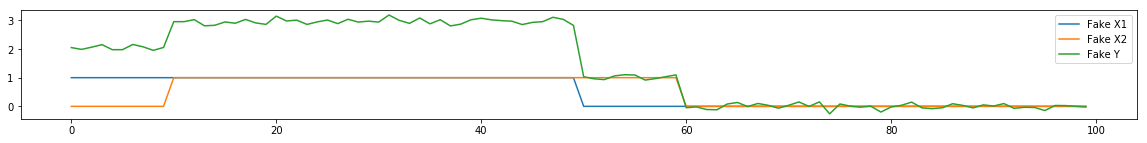

In [74]:
plt.figure(figsize=(20, 2))
plt.plot(fake_multi_x1, label='Fake X1')
plt.plot(fake_multi_x2, label='Fake X2')
plt.plot(fake_multiple_y1, label='Fake Y')
_ = plt.legend()

In [75]:
np.corrcoef(fake_multi_x1, fake_multi_x2)

array([[ 1. ,  0.6],
       [ 0.6,  1. ]])

Now let's use 2 simple linear models to estimate the two coefficients separately.

In [76]:
reg_model_simple1 = LinearRegression()
reg_model_simple1.fit(fake_multi_x1.reshape(-1,1), fake_multiple_y1.reshape(-1,1))
reg_model_simple2 = LinearRegression()
reg_model_simple2.fit(fake_multi_x2.reshape(-1,1), fake_multiple_y1.reshape(-1,1))
print('Real Coefficient 1: %.03f, Simple Estimated Coefficient 1: %.03f' % (coef_real1, reg_model_simple1.coef_[0][0]))
print('Real Coefficient 2: %.03f, Simple Estimated Coefficient 2: %.03f' % (coef_real2, reg_model_simple2.coef_[0][0]))

Real Coefficient 1: 2.000, Simple Estimated Coefficient 1: 2.576
Real Coefficient 2: 1.000, Simple Estimated Coefficient 2: 2.166


That's not so great. Now let's see what happens when we put both independent variables in the model.

In [77]:
designmat_fake_multiple = np.stack((fake_multi_x1, fake_multi_x2), axis=1)
reg_model_multi1 = LinearRegression()
reg_model_multi1.fit(designmat_fake_multiple, fake_multiple_y1.reshape(-1,1))
print('Real Coefficient 1: %.03f, Simple Estimated Coefficient 1: %.03f' % (coef_real1, reg_model_multi1.coef_[0][0]))
print('Real Coefficient 2: %.03f, Simple Estimated Coefficient 2: %.03f' % (coef_real2, reg_model_multi1.coef_[0][1]))

Real Coefficient 1: 2.000, Simple Estimated Coefficient 1: 1.994
Real Coefficient 2: 1.000, Simple Estimated Coefficient 2: 0.969


That's more like it! 

So the multiple regression model can account for the correlation between the two independent variables, and therefore find a much better estimate of the coefficients! That's why it's important to include all the independent variables you think may influence the dependent variable. 

#### Breakout Session
Create three fake vectors of length 100 filled with zeros. Call them `fake_resp_1, fake_resp_2, fake_resp_3`. Next, place an `hrf` starting at location 10 in `fake_resp_1`, starting at location 12 in `fake_resp_2`, and starting at location 20 in `fake_resp_3`. Stack them as columns into a matrix `fake_resp`, and plot them. Compute a `fake_resp_y` by adding up 1 times `fake_resp_1`, 2 times `fake_resp_2` and 3 times `fake_resp_3`. Use linear  regression to perform simple linear regression with each one of the single responses, and then with `fake_resp`. Compare the coefficients.

In [79]:
hrf.shape

(16,)

simple regression 1 coef [ 1.43577904]
simple regression 2 coef [ 2.12914102]
simple regression 3 coef [ 2.89712213]
full regression coef [ 1.  2.  3.]


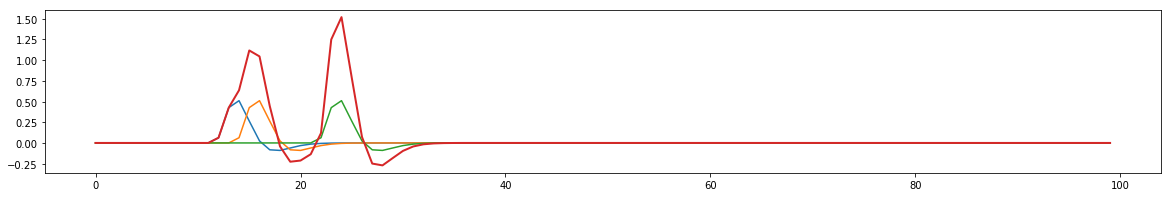

In [84]:
### STUDENT ANSWER
fake_resp_1 = np.zeros(100)
fake_resp_2 = np.zeros(100)
fake_resp_3 = np.zeros(100)
fake_resp_1[10:26] = hrf
fake_resp_2[12:28] = hrf
fake_resp_3[20:36] = hrf
fake_resp = np.stack((fake_resp_1, fake_resp_2, fake_resp_3 ), axis=1)
fake_resp_y = 1 * fake_resp_1 + 2 * fake_resp_2 + 3 * fake_resp_3

plt.figure(figsize=(20, 3))
plt.plot(fake_resp)
plt.plot(fake_resp_y, lw=2)

sreg1 = LinearRegression().fit(fake_resp_1.reshape(-1, 1), fake_resp_y)
sreg2 = LinearRegression().fit(fake_resp_2.reshape(-1, 1), fake_resp_y)
sreg3 = LinearRegression().fit(fake_resp_3.reshape(-1, 1), fake_resp_y)
freg = LinearRegression().fit(fake_resp, fake_resp_y)

print("simple regression 1 coef", sreg1.coef_)
print("simple regression 2 coef", sreg2.coef_)
print("simple regression 3 coef", sreg3.coef_)
print("full regression coef", freg.coef_)
### END STUDENT ANSWER

# Answering Questions in Cognitive Neuroscience

Multiple regression gives us a tool to determine the linear relationship between many independent variables (stimuli or tasks in fMRI experiments) and a single dependent variable (the BOLD signal). So how can we use this tool to learn about the brain? Let's remind ourselves of the types of questions that cognitive neuroscientists ask to better determine how to use this tool.

Cognitive neuroscience is interested in identifying:
* **Mental Processes and Representations and...**
* **Localizing these onto the brain, both spatially and temporally.**

The types of mental processes cognitive neuroscientists study include:
* Attention
* Decision-making
* Learning
* Memory
* Language
* Perception
* Motor system
* Social cognition
* Emotions

So we develop experiments that require the mental processes we're interested in studying, and find regions in the brain that are active when we believe that mental process should be utilized.

We've been looking at perception and the motor system brain data, and so the types of questions we might be interested in asking are:

* How does the visual system recognize a certain type of thing, such as faces or scenes? Are there brain regions that are active specifically to these?
* What brain regions do visual processing in general?
* What brain regions are used to compute and prepare body movements?

Now that we know the types of questions we're interested in answering using fMRI, how can we use multiple linear regression to answer them? The weights that we get from multiple regression tell us how much $y$ increases for every increase of `1` in $x$. And since $y$ is the fMRI brain data, and $x$ are the experimental conditions, we can use these weights to determine when the brain activity increases for various experimental conditions, which quantifies the brain activity increases when the mental processes we want to study are utilized. 

# Functional Localizers & Regions of Interest (ROIs)
As we've just seen, the localization of cognitive proceses to specific brain regions is central to cognitive neuroscience. Thousands of researchers are working towards the goal of understanding the human brain, using many different ways of gaining knowledge and guiding investigation. Some results have been confirmed over and over again, showing that the same brain regions are involved in the same cognitive processes across many subjects and experiments. As such, these findings have established the existence of functional regions that have been given names (such as the FFA and PPA). These functional regions are broadly termed ***regions of interest*** (ROIs). Below are some examples of ROIs within the visual cortex:

rOFA (Faces) in yellow, rLO (Objects) in blue, and rEBA (Bodies) in red
<div>
<br>
<img src="figures/OFA_LO_EBA.png" align="left" style="height: 400px;">
<img src="figures/SingleSubject-Visual.png" align="right" style="height: 400px;">
</div>

New studies build upon and extend these previous findings, and so we want to be able to show how our new findings relate spatially to established ROIs. ***Functional localizers*** are experiments done alongside the main study to *localize* the relevant ROIs, so the new findings can be contextualized with the previous literature. The data we've dealt with up until this point has actually been localizer data, so let's explore how to use that data to find ROIs before going on to ask more interesting questions.

## A Caveat on Intepreting ROIs
It is **very** important to note that *functional regions* do not completely describe the processing done in a specific brain region. While at the spatial resolution that fMRI provides researchers see strong evidence for functional localization, this does not mean that a given brain region **does "X"** (e.g. FFA does face processing). This is just a description at a certain level of abstraction, and the computations actually being carried out in any brain region are far more complex than simple "face processing", or whatever the ROIs is said to do. 

1. At a lower level it is becoming increasingly clear that functional organization is actually continuously varying across cortex.
2. At a higher level, functional regions interact with each other. The function of any given region might also be better described by taking this into account

## Functional Localizer Analysis

Up to this point we've used two different techniques to analyze our visual localizer data and identify cortical regions that respond to different types of visual stimuli (ROIs), such as faces. First we took the mean of all the TRs during the blocks of each type of stimulus presentation. Then we improved this analysis by accounting for the HRF and correlating response vectors with the BOLD signal. Now we'll use multiple regression to account for the overlapping HRFs from adjacent blocks of differing stimulus types. This is the way functional localizers are generally analyzed in contemporary fMRI studies.

Let's start by visualizing the response design matrix so we can see that the response vectors do indeed overlap in time, and so the correlate a little bit, so we want to take that into account when fitting our linear regression model. 

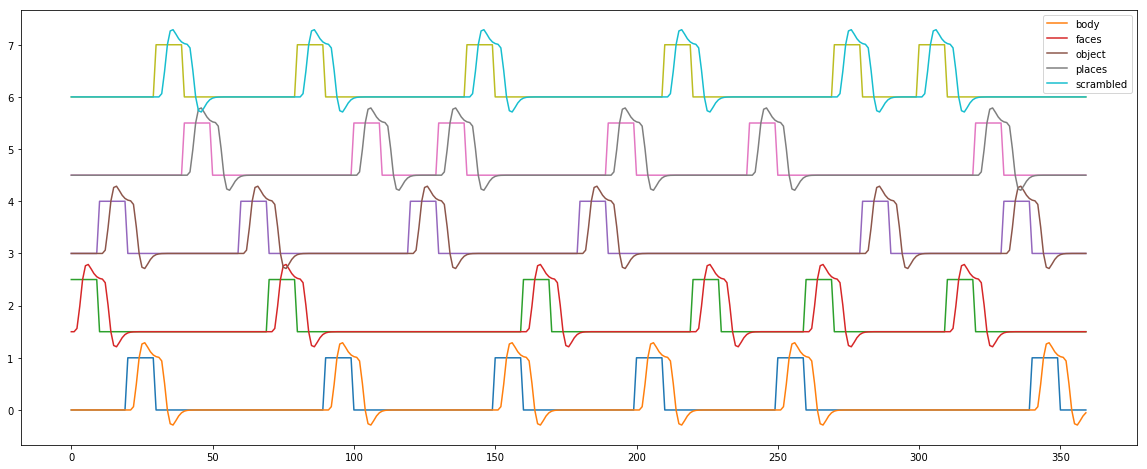

In [85]:
plt.figure(figsize=(20, 8))
for i in range(len(unique_categories_no_nothing)):
    label = unique_categories_no_nothing[i]
    stimulus_timeseries = stimulus_vectors[i]
    response_timeseries = designmat_full[:,i]
    plt.plot(stimulus_timeseries + 1.5 * i)
    plt.plot(response_timeseries + 1.5 * i, label=label)
    
_ = plt.legend()

And let's quantify how correlated the response vectors of the design matrix are.

In [86]:
np.corrcoef(designmat_full.T)

array([[ 1.        , -0.19439421, -0.19436974, -0.20871264, -0.2230066 ],
       [-0.19439421,  1.        , -0.19428054, -0.17995129, -0.22289009],
       [-0.19436974, -0.19428054,  1.        , -0.20858531, -0.17997576],
       [-0.20871264, -0.17995129, -0.20858531,  1.        , -0.19428054],
       [-0.2230066 , -0.22289009, -0.17997576, -0.19428054,  1.        ]])

They are all correlated negatively with a correlation coeffecient value around `0.2`. How much does this correlation effect the weights estimated using a simple linear regression vs. a multiple regression model? To find out we'll fit two models, one using just the faces response vector, and the other using the full design matrix. We'll also z-score both the $x$ and $y$ of both so that they'll both have an intercept close to zero and comparable slopes.

In [87]:
faces_response_vec_z = zscore(faces_response_vec)
reg_model_faces_z = LinearRegression()
_ = reg_model_faces_z.fit(faces_response_vec_z.reshape(-1,1), zscore(data_faces_2D))

designmat_full_z = zscore(designmat_full, axis=0)
reg_model_full_z = LinearRegression()
_ = reg_model_full_z.fit(designmat_full_z, zscore(data_faces_2D))

Since we've z-scored both the $x$ and $y$ data, we should expect the intercept to be around `0`, let's verify that.

In [88]:
reg_model_faces_z.intercept_[0], reg_model_full_z.intercept_[0]

(1.8780054614876755e-09, 1.8780055135672419e-09)

Yup, the intercepts of both models are very close to zero. Now let's compare the weights estimated in both of the models.

In [89]:
reg_model_faces_z.coef_[0,0], reg_model_full_z.coef_[0,1]

(0.61821397101189779, 0.7046653226813695)

So using multiple regression results in a higher weight for the faces regressor in the FFA voxel, indicating a stronger response since we've controlled for the correlation between the 5 indepedent variables (response vectors).

Now let's apply multiple linear regression to all of the cortical voxels. The `LinearRegression` object allows for this natively, let's see how.

In [90]:
reg_model_full_allvoxels = LinearRegression()
_ = reg_model_full_allvoxels.fit(designmat_full_z, data)
reg_model_full_allvoxels.coef_.shape

(38543, 5)

and plot the weights for faces onto a flatmap.

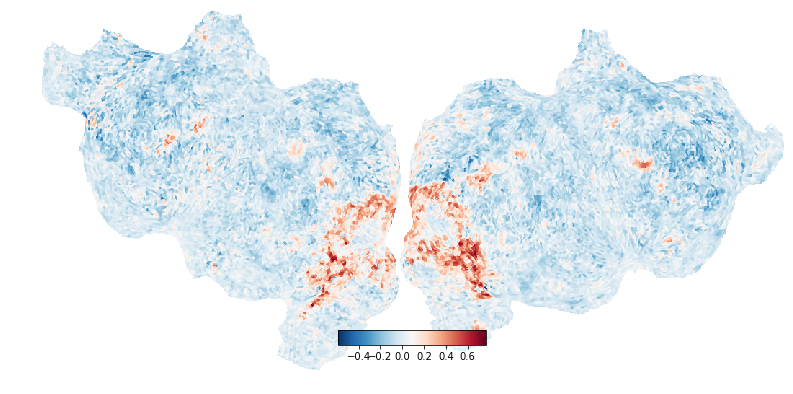

In [91]:
volume_faces_multi = cortex.Volume(reg_model_full_allvoxels.coef_[:,1], subject='s01', xfmname='catloc')
_ = cortex.quickflat.make_figure(volume_faces_multi)

Weird, this flatmap looks different what we've seen when taking the average of block data or using correlation! There is more area that shows high activation (in red). Let's figure out why in the next section.

#### Breakout Session
1\. Plot a flatmap showing the weights for the `places` weights across cortical voxels.

In [ ]:
### STUDENT ANSWER
### END STUDENT ANSWER

## Functional contrasts

The question we are trying to answer with these localizer analyses are: 
> What regions of cortex are selective for faces (or places or bodies, etc.)? 

So how do we answer that question using fMRI? Remember that the BOLD signal is a relative signal, meaning we always have to compare activity in one condition with activity in another condition. We might be tempted to compare the face image condition with the simple resting condition (no stimulus shown). Doing this would tell us how much the BOLD signal increases to images of faces relative to seeing nothing (rest). 

This type of comparison is called a **functional contrast** and is accomplished by fitting a multiple regression model to the BOLD data, and then simply subtracting the weights for condition two (rest) from condition one (faces). Let's do this know, but first we need to update our design matrix to include the `nothing` (or rest) condition. 

In [92]:
nothing_stimulus_vector = categories == 'nothing'
nothing_response_vector = np.convolve(nothing_stimulus_vector, hrf)[:len(nothing_stimulus_vector)]
designmat_full_nothing = np.hstack((designmat_full, nothing_response_vector.reshape(-1,1)))
designmat_full_nothing.shape

(360, 6)

Now we can fit a new multiple regression model that includes the nothing condition so we can have weights for both `faces` and `nothing` for all the cortical voxels which is what we need to create a functional contrast.

In [93]:
reg_model_full_nothing = LinearRegression()
_ = reg_model_full_nothing.fit(designmat_full_nothing, data)

And let's create the functional contrast of `faces - nothing` for all the cortical voxels.

In [94]:
contrast_faces_nothing = reg_model_full_nothing.coef_[:,1] - reg_model_full_nothing.coef_[:,5]
contrast_faces_nothing.shape

(38543,)

Finally we can plot the values of this contrast onto a flatmap to view it.

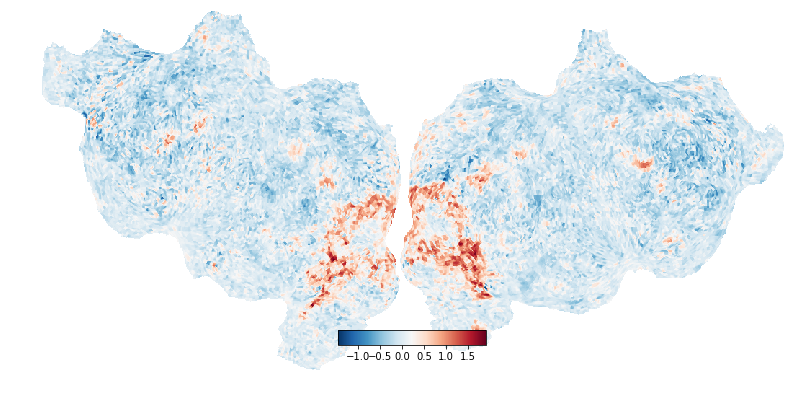

In [95]:
volume_contrast_faces_nothing = cortex.Volume(contrast_faces_nothing, subject='s01', xfmname='catloc')
_ = cortex.quickflat.make_figure(volume_contrast_faces_nothing)

Interesting, this flatmap looks very similar to the one we made in the last section! Now we can go about answering why it looks different than the maps we created by averaging faces blocks or doing correlation.

#### Breakout Session

1\. Why is the BOLD signal relative? Another way to ask this question is why can't we just interpret the raw values of the BOLD signal?

In [ ]:
### STUDENT ANSWER
### END STUDENT ANSWER

2\. Create a constrat for `places - nothing` and call it `contrast_places_nothing`.

In [ ]:
### STUDENT ANSWER
### END STUDENT ANSWER

3\. Now create a flatmap showing this `places - nothing` contrast. How is it similar to the one we just created for `faces - nothing`? And how is it different?

In [ ]:
### STUDENT ANSWER
### END STUDENT ANSWER

### Controlling Cognitive Processes 
In the question above, we asked which regions are face **selective**. Let's get more formal about what we mean by **selective** when talking about ROIs. **Selective** means that a given region responds more to faces than to other types of stimuli. We've learned that there are so called *early visual regions* which process simple (**low-level**) properties of images, such as edges or curves. Since these regions are active whenever there is any kind of visual stimulus we wouldn't want to say they are face selective just because they are active when the subject views images of faces, those regions would be active for any type of image. By comparing BOLD signal increase to images of faces relative to rest we foundactivity in early visual regions as well as the face selective regions. 

A more general way to say this is that we want to account for all the cognitive processes an experiment can engage except for the specific cognitive process we want to study. So in this case we simply want the cognitive process of face processing, but not general low-level visual processing. So how do we go about finding a brain region that is involved in face processing, but not any other cognitive processes? We do this by being smart about the functional contrasts we use. 

**Specifically, we want to compare two experimental conditions that use all of the same cognitive processes except for the specific process being studied.** 

In the case of this visual localizer, we can compare the faces and places conditions since both types of images will ellicit activity in the early visual regions. Let's have a look.

In [96]:
unique_categories_no_nothing

array(['body', 'faces', 'object', 'places', 'scrambled'], 
      dtype='<U9')

In [97]:
contrast_faces_places = reg_model_full_nothing.coef_[:,1] - reg_model_full_nothing.coef_[:,3]
contrast_faces_places.shape

(38543,)

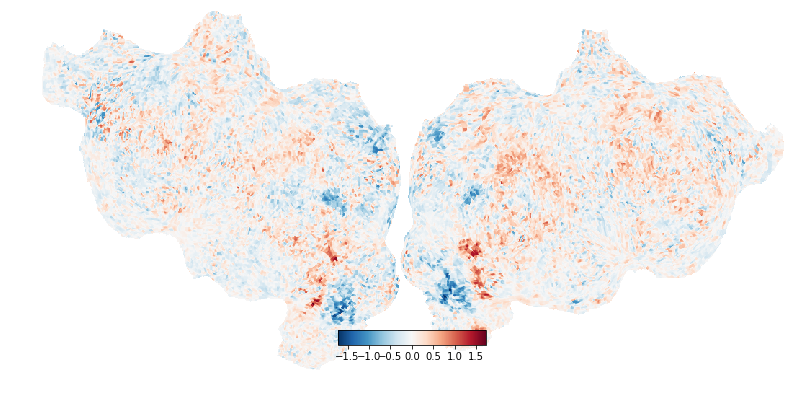

In [98]:
volume_contrast_faces_places = cortex.Volume(contrast_faces_places, subject='s01', xfmname='catloc')
_ = cortex.quickflat.make_figure(volume_contrast_faces_places)

That looks much better! We see the face selective regions in dark red (FFA and OFA) that we saw by averaging blocks or correlating response and BOLD data vectors. This map is different, however. There are regions of dark blue that weren't there before, and much of cortex is light red. 

The dark blue regions are actually place selective regions, and come from the fact that we subtracted the places weights for this contrast. 

Now let's just remind ourselves what the correlation map looked like.

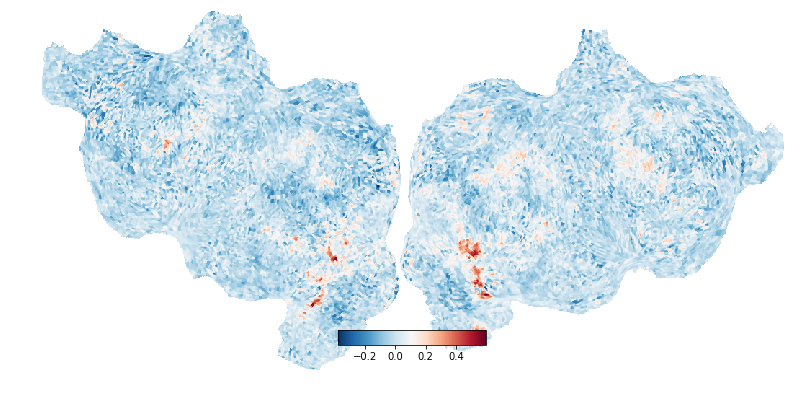

In [99]:
corr_faces_bold = correlate(faces_response_vec, data)
volume_corr_faces_bold = cortex.Volume(corr_faces_bold, subject='s01', xfmname='catloc')
_ = cortex.quickflat.make_figure(volume_corr_faces_bold)

#### Breakout Session

1\. Create the `places - faces` contrast and call it `contrast_places_faces`.

In [ ]:
### STUDENT ANSWER
### END STUDENT ANSWER

2\. Plot the flatmap for the `places - faces` contrast.

In [ ]:
### STUDENT ANSWER
### END STUDENT ANSWER

### Qualitative vs. Quantitative ROIs

In all of these analysis we've simply been finding regions that have high activity for the functional contrast we're looking at, and saying that general region is the ROI in question (e.g. FFA). This is a very **qualitative** way of deciding on the location of the ROI, and we would like to be more **quantitative**. In other words, we want to be able to define some kind of threshold and say any voxel whose activity increases X amount under the contrast we will say is part of the ROI. The quantitative threshold we will use for this will be calculated by finding voxels whose increase in activity is **signifcantly** greater than zero. We will learn how to do this next week when we cover hypothesis testing and permutation testing.

# Common ROIs


### The Fusiform Face Area (FFA) (Kanwisher et al. 1997, http://www.jneurosci.org/content/17/11/4302)

<img src='figures/F1.large.jpg'>
**Figure caption from paper:** *"Results of Part II. Left column, Sample stimuli used for the faces versus objects comparison as well as the two subsequent tests. Center column, Areas that produced significantly greater activation for faces than control stimuli for subject S1. a, The faces versus objects comparison was used to define a single ROI (shown in green outline for S1), separately for each subject. The time courses in the right column were produced by (1) averaging the percentage signal change across all voxels in a given subject’s ROI (using the original unsmoothed data), and then (2) averaging these ROI-averages across the five subjects. F andO in a indicate face and object epochs;I and S in b indicate intact and scrambled face epochs; and F andH in c indicate face and hand epochs."*

### FFA via faces > places contrast

Looking at unique labels, we can see that faces has index 1 and places has index 3. So let's subtract them!

In [100]:
weights = reg_model_full_allvoxels.coef_

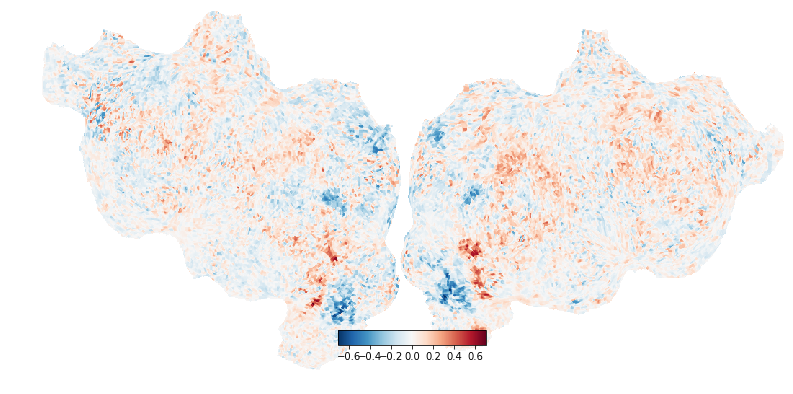

In [101]:
face_contrast = weights[:, 1] - weights[:, 3]

_ = cortex.quickshow(cortex.Volume(face_contrast, 's01', 'catloc'))

The lower "blobs" are FFA, the bigger one higher up is OFA

### The Parahippocampal Place Area (Epstein et al. 1999, https://www.nature.com/articles/33402)

<img src='figures/392598aa.eps.2.gif'>
**Figure caption from paper:** *"Results of experiment 1, demonstrating that the PPA responds selectively to scenes. **a** Examples of intact and scrambled versions of the four different types of stimuli (top), and the average percent signal change for each stimulus type in the PPA averaged over all subjects (bottom). The difference between intact and scrambled versions of each picture is a measure of the response in the PPA to each stimulus type partially unconfounded from the response to its low-level visual features. Half of the scenes were outdoor scenes of the MIT campus, and half were indoor scenes
of
un
familiar
locations.
b
,
The
tim
e
course
of
the
per
cent
change
in
MR
signal
inten
sity
in
the
PP
A
ov
er
the
pe
riod
of
the
scan.
P
er
cent
signal
change
was
calcu
lated
individ
ually
for
each
subje
ct
using
that
subject’
s
fixation
activation
as
baseline
and
then
aver
aging
a
cr
oss
subje
cts
(black
dot
indicates
fixation
epochs).
i,
Intact
;
s,
scr
am
bled;
S,
sce
nes;
F
,
faces;
O,
objects;
H,
hous
es"*


<img src='figures/392598ab.eps.2.gif'>

### PPA via places > objects contrast

Places has index 3, objects has index 2

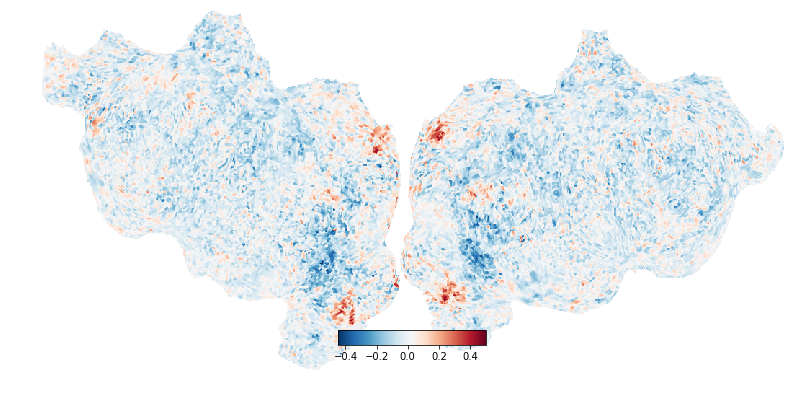

In [105]:
place_contrast = weights[:, 3] - weights[:, 2]

_ = cortex.quickshow(cortex.Volume(place_contrast, 's01', 'catloc'))

The bottom area is PPA, the top area is RSC, the middle area is OPA.

### EBA via bodies > objects contrast

Body has index 0, object has index 2

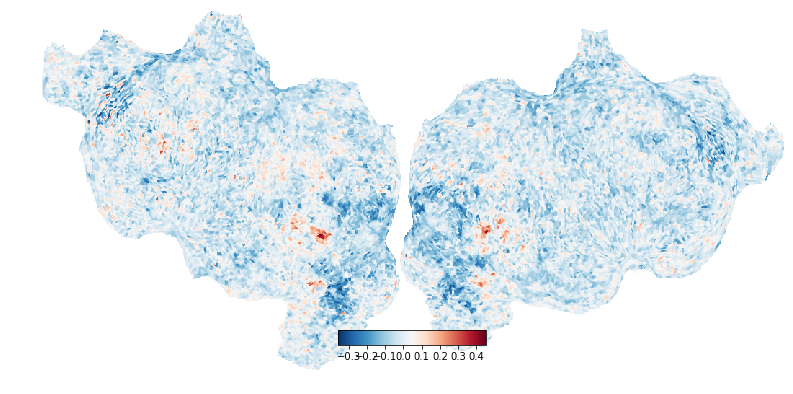

In [103]:
body_contrast = weights[:, 0] - weights[:, 2]

_ = cortex.quickshow(cortex.Volume(body_contrast, 's01', 'catloc'))

### Lateral Occipital Complex (LO)
<img src='figures/loc brain.png'>
<img src='figures/loc stimulus.png'>
<img src='figures/nrn3747-f3.jpg'>

The biggest "blobs" in the middle are EBA

### LO via object > scrambled contrast

The Lateral Occipital (LO) region is selective to objects. 

Object has index 2, scrambled has index 4

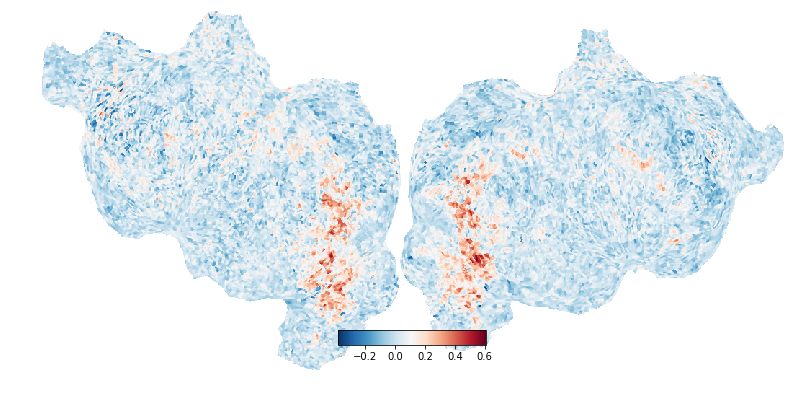

In [106]:
object_contrast = weights[:, 2] - weights[:, 4]

_ = cortex.quickshow(cortex.Volume(object_contrast, 's01', 'catloc'))

This one is hard to tell for this subject as much of visual cortex is active here. LO is the region closest to the top of the image on both sides.